In [1]:
import sys, os


sys.path.insert(0, '../../../residual2vec_')


In [2]:
os.environ['DISABLE_WANDB'] = 'true'

#disable epoch level tqdm
os.environ['DISABLE_TQDM'] = 'true'
# checking if imports working
from node2vec import node2vecs
from utils import snakemake_utils
from sklearn.decomposition import PCA
import pandas as pd 
from torch_geometric.data import download_url, extract_zip
import networkx as nx 
import numpy as np 
from scipy import sparse 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pickle as pkl
from urllib.request import urlopen
from zipfile import ZipFile

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
embs = pkl.load(open("../../../final_/demonstration_embs.pkl", "rb"))
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v'])

In [4]:
source_data_url = "http://www-personal.umich.edu/~mejn/netdata/polbooks.zip"

tmp_gml_file = "/tmp/data"
zipresp = urlopen(source_data_url)
tempzip = open("/tmp/polbooks.zip", "wb")
tempzip.write(zipresp.read())
tempzip.close()
zf = ZipFile("/tmp/polbooks.zip")
zf.extractall(path = tmp_gml_file)
zf.close()


graph_data_file = tmp_gml_file + "/" + "polbooks.gml"

G = nx.read_gml(graph_data_file)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)
 
deg = np.array(A.sum(axis=1)).reshape(-1)
A = (sparse.diags(deg) @ A @ sparse.diags(deg))


In [5]:
embs['n2v'] = snakemake_utils.get_embs_from_dataset(dataset_name='polbook', crosswalk=False, r2v=False, 
                                                    node2vec=True, fairwalk=False, model_name='node2vec',
                                                    learn_outvec=False, model_dim=16, adj=A)


Using existing file polbooks.gml
/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '
Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1050/1050 [00:00<00:00, 55072.27it/s]


Using existing file polbooks.zip
Extracting /tmp/ashutiwa/polbooks.zip


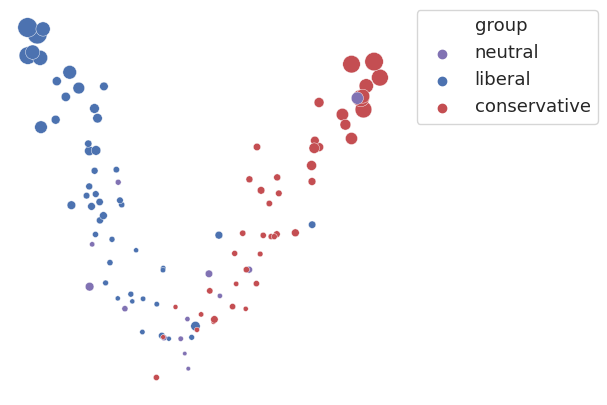

In [6]:
DIM = 16

extract_zip(download_url("http://www-personal.umich.edu/~mejn/netdata/polbooks.zip", "/tmp/ashutiwa/"), "/tmp/ashutiwa/", True)
DATA_FILE = '/tmp/ashutiwa/polbooks.gml'
G = nx.read_gml(DATA_FILE)
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G)

def plot_embs(emb, degree, gp_ids, sizes=(10, 200), figsize=(5, 5)):
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data  = pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in gp_ids],
                "model": "Biased",
                "degree": degree
            }
        )

    # %%
    sns.set_style('white')
    sns.set(font_scale=1.0)
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=figsize)
    colors = ["blue", "red", "purple"]
    cmap = sns.color_palette()
    colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}
    g= sns.scatterplot(data = plot_data, x = "x", y = "y", hue = "group", size = "degree", sizes=sizes, palette = colors, ax = ax)
    ax.legend()
    h,l = g.get_legend_handles_labels()
    plt.legend(h[0:4],l[0:4],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)
    
    ax.axis("off")
    
deg = np.array(A.sum(axis=1)).reshape(-1)

A = (sparse.diags(deg) @ A @ sparse.diags(deg))
deg_ = np.array(A.sum(axis=1)).reshape(-1)

plot_embs(emb=embs['Biased'], degree=deg_, gp_ids=group_ids)

# remove degree debiased
# drop fairwalk
# all these 8 images in one



# only deepwalk here 

In [7]:
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v', 'n2v'])

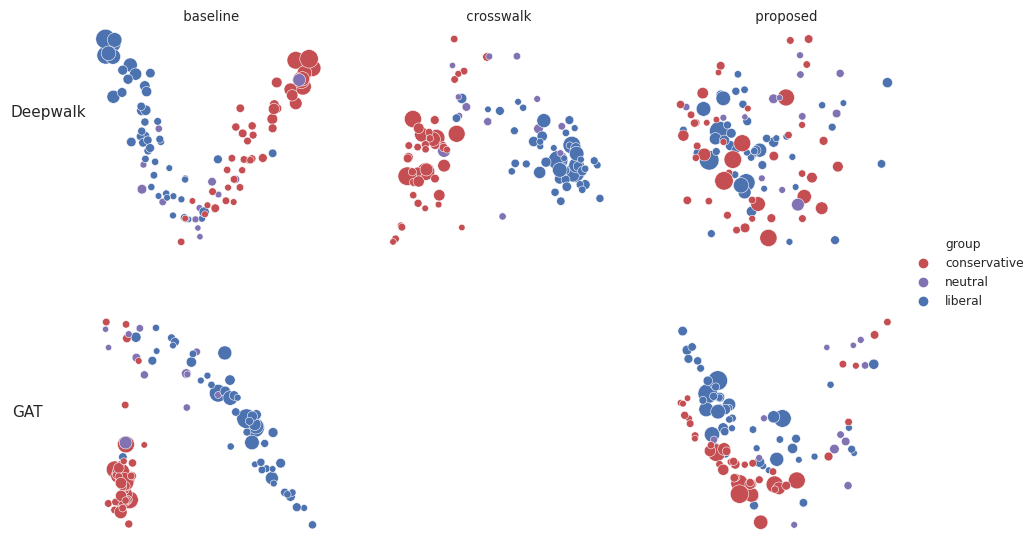

In [8]:
plot_data_all = []

# deg = np.array(A.sum(axis=0)).reshape(-1)
row = 0
ordered_ = ['Biased', 'cw_dw', 'Degree-Group-debiased', 'gat_dw_random', 'gat_n2v_r2v', 'gat_dw_r2v', ] 

mp = {'Biased': 'baseline',
    'gat_n2v_random': 'gat-node2vec-random-sampling', 'gat_n2v_r2v': 'gat-node2vec-biased-sampling', 
    'gat_dw_random': 'deepwalk-random-sampling', 'gat_dw_r2v': 'deepwalk-biased-sampling',
     'gcn_dw_random': 'deepwalk-random-sampling', 'gcn_dw_r2v': 'deepwalk-biased-sampling',
   'fw_dw': 'fairwalk-deepwalk', 'cw_dw': 'crosswalk', 'fw_n2v': "fairwalk-node2vec", 'cw_n2v': "crosswalk-node2vec",  
'Degree-Group-debiased': 'proposed'}
# mp = {
#     'gat_dw_random': 'biased', 'gat_dw_r2v': 'unbiased', 'Biased': 'biased', 'cw_dw': 'unbiased'
# }
for idx, k in enumerate(ordered_):
#     if k not in keys: continue
    emb = embs[k]
#     print(k)
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in group_ids],
                "model": mp[k],
                "degree": deg_,
    
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=.8)
sns.set_style("ticks")

# fig, ax = plt.subplots(figsize=(7,5))

g = sns.FacetGrid(
    data=plot_data_all,
#     row="row",
    col='model',
    sharex=False,
    sharey=False,
    col_wrap=3
    
)


cmap = sns.color_palette()
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}
g.map(sns.scatterplot, "x", "y", "group", "degree", sizes=(20, 200), palette = colors)
# g.fig.suptitle("WORD2VEC")
# g.axes[0, 0].legend()


for (i,j,k), data in g.facet_data():

    ax = g.facet_axis(i, j)
    # need to see a better way of removing title
    title = ax.get_title()
    ax.set_title(title.replace("model =", ""))
    if j > 2:
        # removing top title
        ax.set_title("")
    # adding left text
    if j in [0, 3]:
        if j == 0:
            ax.text(-2.7, .3,'Deepwalk', fontsize = 11)
        if j == 3:
            ax.text(-2.7, .3,'GAT', fontsize = 11)
    ax.set_axis_off()
    h,l = ax.get_legend_handles_labels()
#     print(i, j)
    # removing fifth plot
    if j == 4: ax.remove()
#     ax.legend(h[0:4],l[0:4],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=5)
#     print(h, l)


g.add_legend(legend_data={i: g._legend_data[i] for i in ['group', 'conservative', 'neutral', 'liberal']})
# plt.legend(labels=['legendEntry1', 'legendEntry2', 'legendEntry3'])

baseline
node2vec
crosswalk
proposed
deepwalk-random-sampling
deepwalk-biased-sampling


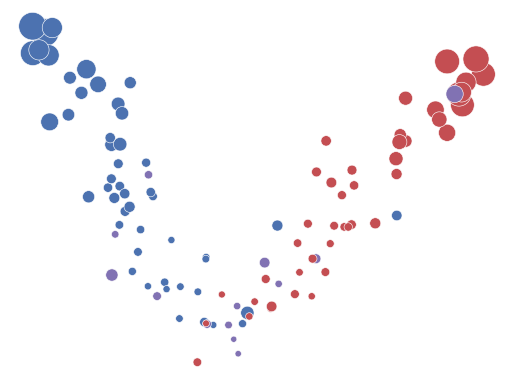

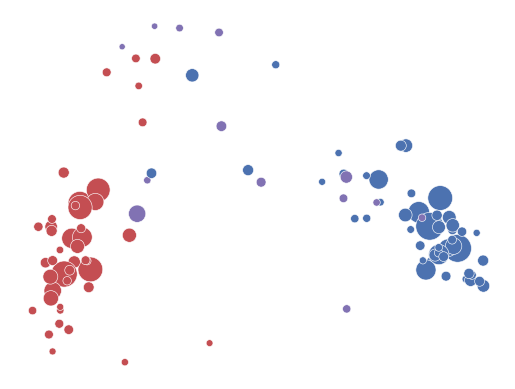

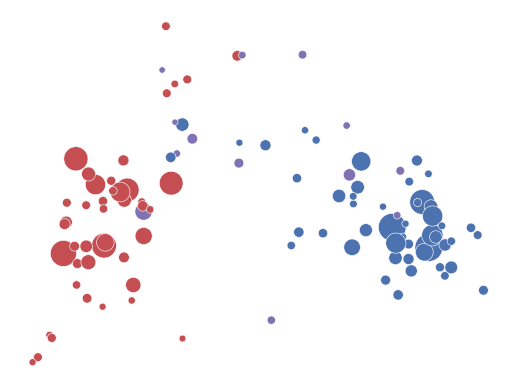

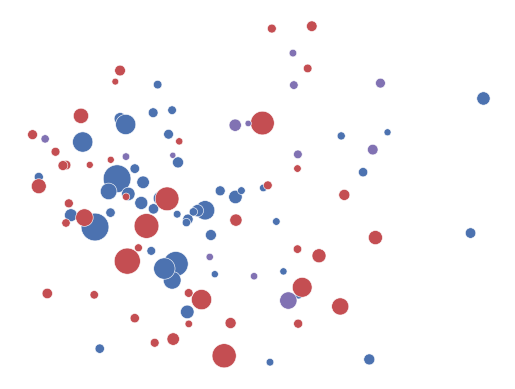

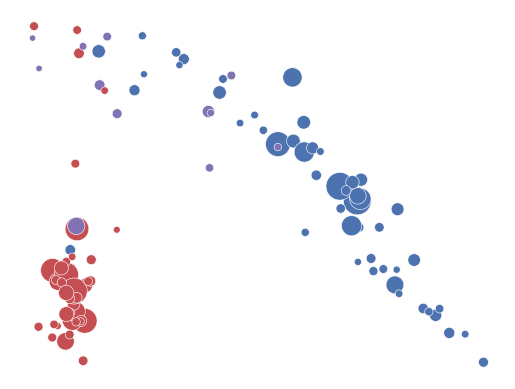

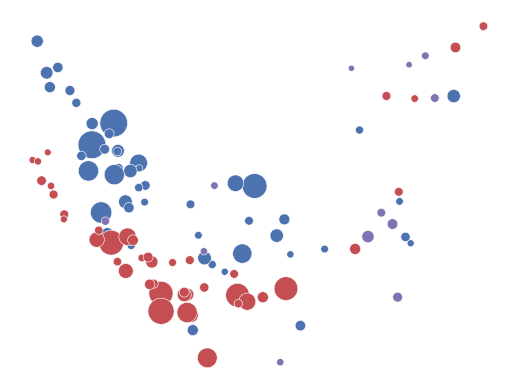

In [9]:
plot_data_all = []

# deg = np.array(A.sum(axis=0)).reshape(-1)
row = 0
ordered_ = ['Biased', 'n2v', 'cw_dw', 'Degree-Group-debiased', 'gat_dw_random', 'gat_dw_r2v', ] 

mp = {'Biased': 'baseline',
    'gat_n2v_random': 'gat-node2vec-random-sampling', 'gat_n2v_r2v': 'gat-node2vec-biased-sampling', 
    'gat_dw_random': 'deepwalk-random-sampling', 'gat_dw_r2v': 'deepwalk-biased-sampling',
     'gcn_dw_random': 'deepwalk-random-sampling', 'gcn_dw_r2v': 'deepwalk-biased-sampling',
   'fw_dw': 'fairwalk-deepwalk', 'cw_dw': 'crosswalk', 'fw_n2v': "fairwalk-node2vec", 'cw_n2v': "crosswalk-node2vec",  
'Degree-Group-debiased': 'proposed', 'n2v': 'node2vec'}
# mp = {
#     'gat_dw_random': 'biased', 'gat_dw_r2v': 'unbiased', 'Biased': 'biased', 'cw_dw': 'unbiased'
# }
for idx, k in enumerate(ordered_):
#     if k not in keys: continue
    emb = embs[k]
#     print(k)
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in group_ids],
                "model": mp[k],
                "degree": deg_,
    
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=.8)
sns.set_style("ticks")



cmap = sns.color_palette()
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}

for o in ordered_:
#     sns.scatterplot("x", "y", "group", "degree", palette = colors)

    
    plt.figure()
    print(mp[o], )
    ax = sns.scatterplot(data=plot_data_all[plot_data_all.model == mp[o]], x="x", y="y", 
                    size="degree", palette=colors, hue="group", sizes=(20, 400))
    
    # remove axis
    ax.set_axis_off()
    plt.legend([], [], frameon=False)
    plt.plot();

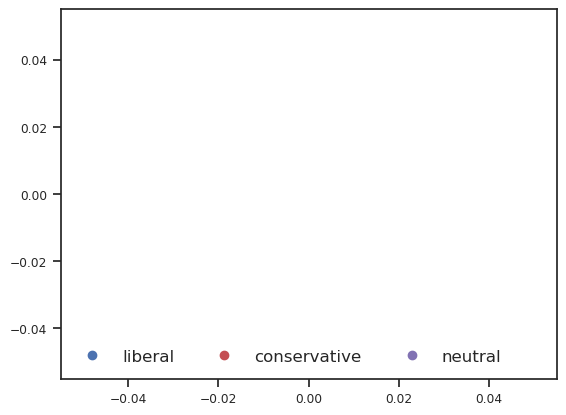

In [10]:
colors = [cmap[0], cmap[3], cmap[4]]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("o", colors[i]) for i in range(3)]
# print(handles)
labels = ['liberal','conservative','neutral']
legend = plt.legend(handles, labels, loc=3, framealpha=1, frameon=False, prop={'size': 12}, ncol=3)

def export_legend(legend, filename="demonstration.png"):
    fig  = legend.figure
    fig.canvas.draw()
    

    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()

In [11]:
embs.keys()

dict_keys(['Biased', 'Degree-debiased', 'Degree-Group-debiased', 'Degree-Group-debiased-temp', 'fw_n2v', 'fw_dw', 'cw_n2v', 'cw_dw', 'gat_dw_random', 'gcn_dw_random', 'gat_n2v_random', 'gcn_n2v_random', 'gat_dw_r2v', 'gcn_dw_r2v', 'gat_n2v_r2v', 'gcn_n2v_r2v', 'n2v'])

Biased
gat_dw_random
cw_dw
n2v
Degree-Group-debiased
gat_dw_r2v
gcn_dw_r2v


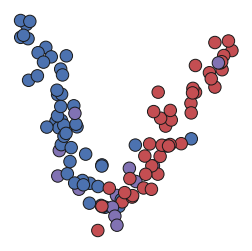

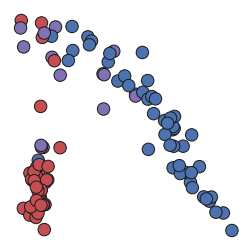

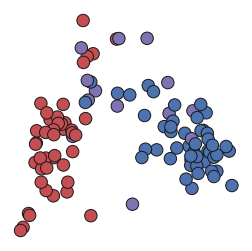

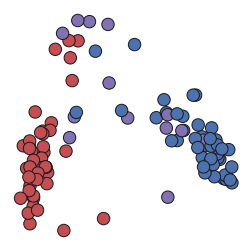

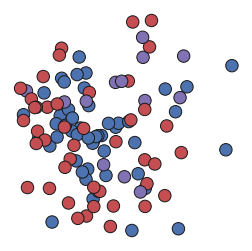

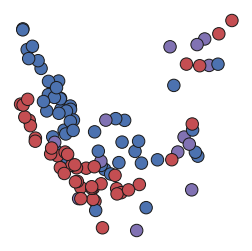

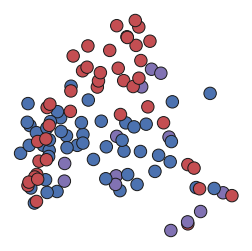

In [12]:
plot_data_all = []

# deg = np.array(A.sum(axis=0)).reshape(-1)
row = 0
ordered_ = ['Biased', 'gat_dw_random', 'cw_dw', 'n2v', 'Degree-Group-debiased', 'gat_dw_r2v','gcn_dw_r2v' ] 

mp = {'Biased': 'baseline',
    'gat_n2v_random': 'gat-node2vec-random-sampling', 'gat_n2v_r2v': 'gat-node2vec-biased-sampling', 
    'gat_dw_random': 'deepwalk-random-sampling', 'gat_dw_r2v': 'deepwalk-biased-sampling',
     'gcn_dw_random': 'deepwalk-random-sampling', 'gcn_dw_r2v': 'deepwalk-biased-sampling',
   'fw_dw': 'fairwalk-deepwalk', 'cw_dw': 'crosswalk', 'fw_n2v': "fairwalk-node2vec", 'cw_n2v': "crosswalk-node2vec",  
'Degree-Group-debiased': 'proposed', 'n2v': 'node2vec'}
# mp = {
#     'gat_dw_random': 'biased', 'gat_dw_r2v': 'unbiased', 'Biased': 'biased', 'cw_dw': 'unbiased'
# }
for idx, k in enumerate(ordered_):
#     if k not in keys: continue
    emb = embs[k]
#     print(k)
    xy = PCA(n_components=2).fit_transform(emb)
    plot_data_all += [
        pd.DataFrame(
            {
                "x": xy[:, 0],
                "y": xy[:, 1],
                "group": [{0: 'liberal', 1:'conservative', 2:'neutral'}[i] for i in group_ids],
                "model": k,
                "degree": deg_,
    
            }
        )
    ]

plot_data_all = pd.concat(plot_data_all)
#
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")



cmap = sns.color_palette()
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}

for o in ordered_:
#     sns.scatterplot("x", "y", "group", "degree", palette = colors)

    fig, ax = plt.subplots(figsize=(3,3))
 
    print(o)
    g = sns.scatterplot(data=plot_data_all[plot_data_all.model == o], x="x", y="y", 
                    edgecolor="k", palette=colors, hue="group"
          ,              s=80,
    ax=ax,)
    
    # remove axis
    ax.set_axis_off()
    plt.legend([], [], frameon=False)
    ax.axis("off")

    plt.plot();


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


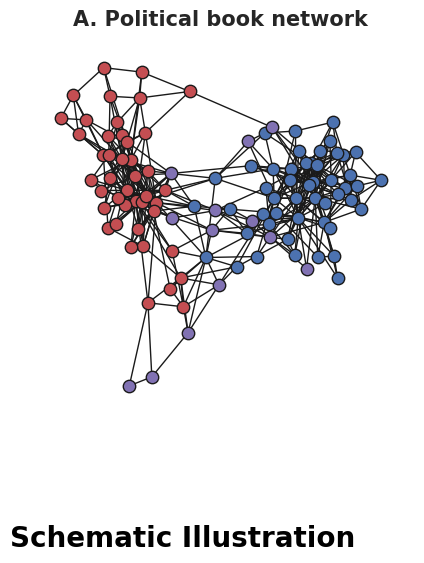

In [13]:

sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
FIG, AX = plt.subplots(figsize=(5,5))

pos = nx.spring_layout(G)


network =pd.DataFrame({
        "x": [pos[i][0] for i in pos],
        "y":[pos[i][1] for i in pos],
        "group": [{0:'liberal', 1:'conservative', 2:'neutral'}[i] for i in group_ids],
        "model": ['network'] * len(group_ids),
        "degree": [1.] * len(group_ids)
    })

df = plot_data_all[plot_data_all.model.isin(['Biased', 'cw_dw', 'gat_dw_random',
       'gat_dw_r2v', 'gcn_dw_r2v', 'Degree-Group-debiased'])]
# df = pd.concat(df, axis=0, ignore_index=True)
node_opts = {"edgecolors": "k",  "ax":AX, "node_size": 80}
cmap = sns.color_palette()
colors = {'liberal': 'blue', 'conservative': 'red', 'neutral': 'purple'}
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 0)[0], node_color=cmap[0], **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 1)[0], node_color=cmap[3], **node_opts
)
nx.draw_networkx_nodes(
    G, pos = pos, nodelist=np.where(group_ids == 2)[0], node_color=cmap[4], **node_opts
)
nx.draw_networkx_edges(G, pos)
AX.axis("off")

plt.text(-1.3, -1.2, "Schematic Illustration", horizontalalignment='left', 
         color='black', weight='bold', fontsize=20)
plt.title("A. Political book network", fontdict={'fontsize': 15, 'fontweight': 'heavy'})
plt.savefig("polbook.png", dpi="figure", )

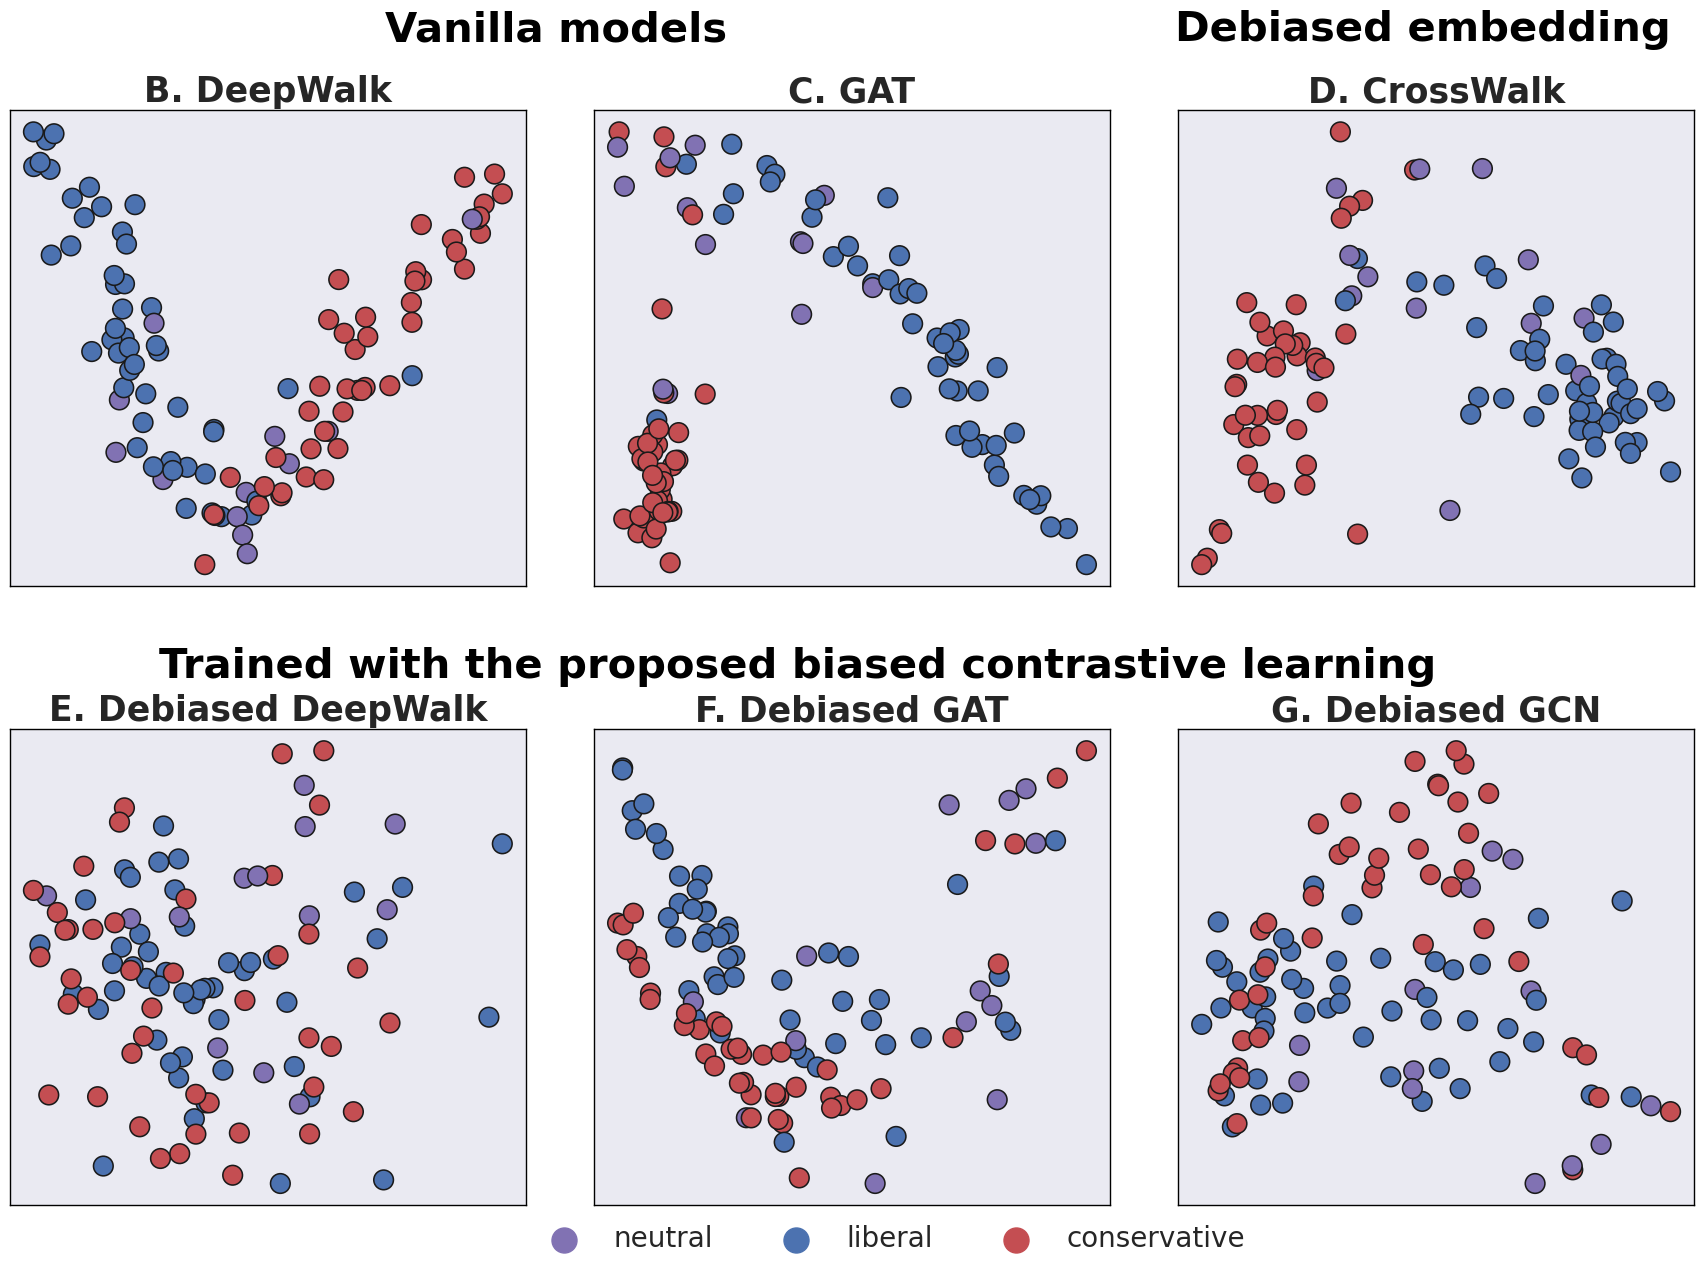

In [14]:
sns.set()
g = sns.FacetGrid(
    data=df,
#     row="row",
    col='model',
    sharex=False,
    sharey=False,
    col_wrap=3,
    height=6,
    despine=True,
    legend_out=True
    
)
cmap = sns.color_palette()
colors = {'liberal': 'blue', 'conservative': 'red', 'neutral': 'purple'}
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}

g.map(sns.scatterplot, "x", "y", "group", sizes=(20, 200), palette = colors, s=200, edgecolor="k")
mapping = {
    'network': 'A. Political book network', 'Biased': 'B. DeepWalk', 
    'gat_dw_random': 'C. GAT', 'cw_dw': 'D. CrossWalk', 'n2v': 'Schematic Illustration', 
    'gat_dw_r2v': 'F. Debiased GAT', 'gcn_dw_r2v': 'G. Debiased GCN', 'Degree-Group-debiased': 'E. Debiased DeepWalk'
}


# for ax in g.axes.flatten(): # Loop directly on the flattened axes 
    
        
for (i,j,k), data in g.facet_data():

    ax = g.facet_axis(i, j)
    # need to see a better way of removing title
    title = ax.get_title()
    title = title.replace("model = ", "")
    title = mapping[title]
#     ax.set_axis_off()
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight': 'heavy'})
    
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)
        
        
    
    ax.set_xticks([])
    ax.set_yticks([])
#     if j not in [0, 4]:
# #         print(ax.figure.get_figwidth(), ax.figure.get_figheight())
#         ax.figure.set_figwidth(20)
#         ax.figure.set_figheight(9)

plt.text(0-6.2, 6.2, "Vanilla models", horizontalalignment='left', 
color='black', weight='bold', fontsize=30)
plt.text(0-1.3, 6.2, "Debiased embedding", horizontalalignment='left', 
    color='black', weight='bold', fontsize=30)

plt.text(0-7.6, 2., "Trained with the proposed biased contrastive learning", horizontalalignment='left', 
         color='black', weight='bold', fontsize=30)
# plt.text(0-17.2, 0, "Schematic Illustration", horizontalalignment='left', 
#          size='medium', color='black', weight='bold', fontsize=30)
g.add_legend(markerscale=3)
g.set_axis_labels(x_var="", y_var="")
plt.subplots_adjust(hspace=0.3)
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.005), ncol=3, fontsize=20)

plt.savefig("demonstration_deepwalk.png", dpi="figure", )
plt.show()

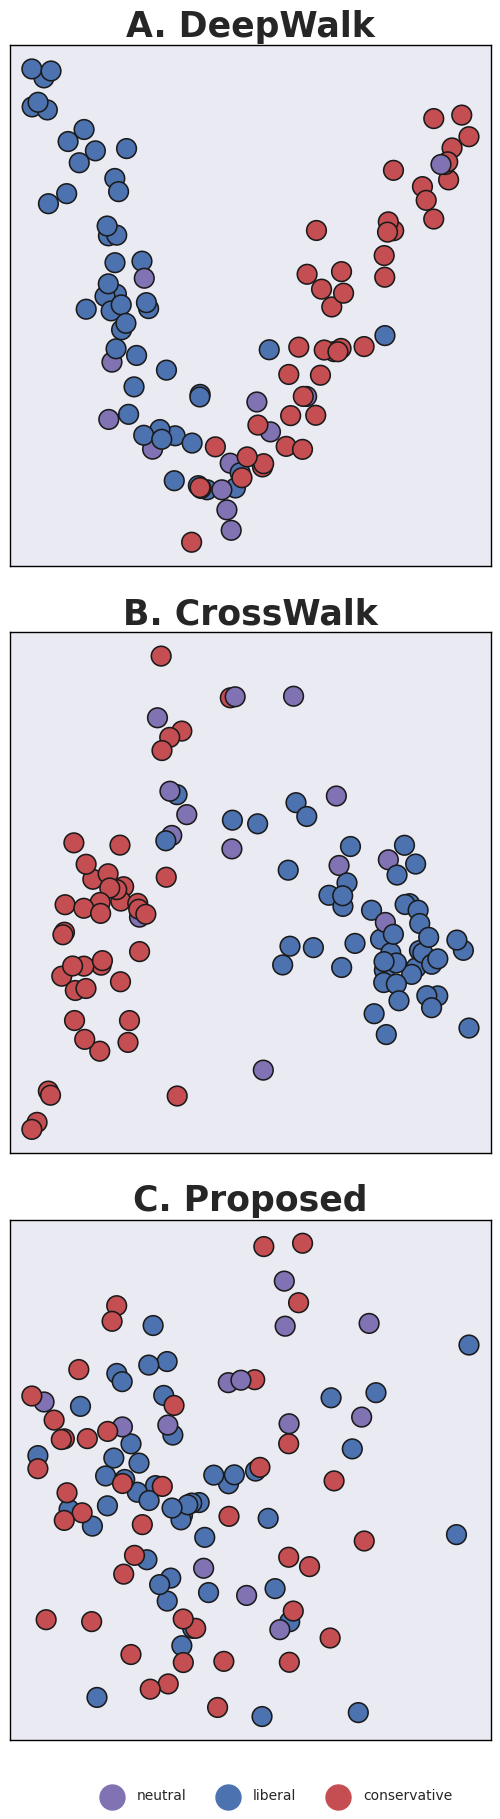

In [15]:
mapping = {
    'Biased': 'A. DeepWalk', 'cw_dw': 'B. CrossWalk', 'Degree-Group-debiased': 'C. Proposed'
#     'gat_dw_random': 'C. GAT', 'cw_dw': 'D. CrossWalk', 'n2v': 'Schematic Illustration', 
#     'gat_dw_r2v': 'F. Debiased GAT', 'gcn_dw_r2v': 'G. Debiased GCN', 'Degree-Group-debiased': 'E. Debiased DeepWalk'
}
sns.set()
g = sns.FacetGrid(
    data=df[df.model.isin(mapping)],
#     row="row",
    col='model',
    sharex=False,
    sharey=False,
    col_wrap=1,
    height=6,
    despine=True,
    legend_out=True
    
)
cmap = sns.color_palette()
colors = {'liberal': 'blue', 'conservative': 'red', 'neutral': 'purple'}
colors = {'liberal': cmap[0], 'conservative': cmap[3], 'neutral': cmap[4]}

g.map(sns.scatterplot, "x", "y", "group", sizes=(20, 200), palette = colors, s=200, edgecolor="k")



# for ax in g.axes.flatten(): # Loop directly on the flattened axes 
    
        
for (i,j,k), data in g.facet_data():

    ax = g.facet_axis(i, j)
    # need to see a better way of removing title
    title = ax.get_title()
    title = title.replace("model = ", "")
    title = mapping[title]
#     ax.set_axis_off()
    ax.set_title(title, fontdict={'fontsize': 25, 'fontweight': 'heavy'})
    
    for _, spine in ax.spines.items():
        spine.set_visible(True) # You have to first turn them on
        spine.set_color('black')
        spine.set_linewidth(1)
        
        
    
    ax.set_xticks([])
    ax.set_yticks([])

g.add_legend(markerscale=3)
g.set_axis_labels(x_var="", y_var="")
sns.move_legend(g, "lower center", bbox_to_anchor=(.5, -0.005), ncol=3, fontsize=10)
plt.savefig("demonstration_abstract.png", dpi="figure", )
plt.show()